# Simulating null distributions for outlier scans

In [2]:
import msprime, tskit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

We are interested in understanding the divergence between two species and have been analysing Fst in windows of 32kb for a sample of 2 diploid individuals per species and have observed some tantalizing outliers.

In [ ]:
#Import Fst scan for chromosome 18 for Heliconius melpomene and Heliconius cydno 

### A super simple toy example

We want to get a feel for the distribution of $F_{st}$ under a really simple null model given 32kbn windows and a recombination rate of 1.84 10^-8 (average $r$ per base from Davey et al. 2017). To define a strict split (i.e. no gene flow) at time $T=0.5$ ($\times 2N_e$ generations) and assuming $N_e=500000$ in msprime:

In [137]:
#number of samples (2Xof diploid individuals) per deme:
sample_size = 10

#Rates for migration, recombination and mutation are unscaled and per generation:
seqLength = 32e3 
recr = 1.84675e-8
Ne = 5e5
splitT = 5e5

population_configurations = [
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne),
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne),
    ]
#demographic events are specified in the order they occur backwards in time:
# MassMigration specifies the split between population 0 and 1: 
# backwards in time all lineages from the smaller population (1) are derived from pop (0)
# at time T 
demographic_events = [
    msprime.MassMigration(time=splitT, source=1, destination=0, proportion=1.0),
    ]

We want to simulate a largish - say 200 - number of replicate windows under this history in msprime. Simulations are pseudorandom, i.e. we start by generating a vector of random seeds:

In [138]:
num_reps = 200
seed = np.random.randint(1, 2**32 - 1, 1)
#seed = np.random.randint(1, 2**32 - 1, 1)
replicates = msprime.simulate(
        num_replicates = num_reps,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        random_seed=seed)

Note that we have not specified any mutation rate, the code-chunck above simulates tree sequences!

However, we can compute any summary statistic that can be defined in terms of branch lenghts directly from the treesequences. We will use the following $F_{st}$ definition:

$F_{st}= \frac{T_b-T_w}{T_b+T_w}$

where $T_w$ and $T_b$ are the average pairwise coalescence times for a pair of lineages sampled within and between species respectively. Therefore an estimator of $F_{st}$ is:

$\hat{F_{st}}= \frac{d_{xy}-\pi}{d_{xy}+\pi}$

Note that the above follows from the general definition of $F_{st}$ in terms of expected pairwise coalescence times:

$F_{st}= \frac{T_t-T_w}{T_{t}}$

Where $T_t$ is the average for a pairwise sample taken at random. For the case of pops/species we assume that we are equally likely to sample from within and between species, so:

$T_t=(T_b + T_w)/2$

In [ ]:
#Update with tskit version. Insert an explanation of tskit.BranchLengthStatCalculator
#Running this takes about 3 minutes: 

In [139]:
def Fst(div_entry):
    A = np.mean((div_entry.diagonal()))
    B = div_entry[1,0]
    return (B-A)/(A+B)

def calculate_Fst(ts, samplesets, function=Fst):
    winlen = [0,ts.sequence_length]
    BranchStat = tskit.BranchLengthStatCalculator(ts)
    div_matrix = BranchStat.divergence_matrix(samplesets,winlen)
    Fst_result = list(map(function, div_matrix))
    return Fst_result

fstSims = np.zeros(num_reps)
for index, ts in enumerate(replicates):
    p1 = list(ts.get_samples(0))
    p2 = list(ts.get_samples(1))
    fstSims[index] = calculate_Fst(ts,samplesets=[p1,p2])[0]

The mean $F_{st}$ is:

In [123]:
fstSims.mean()

0.19836298386831072

The expected $F_{st}$ under the this model can be found using the coalescence definition above and $E[T_w]=1$ and $E[T_b]=T+1$ and matches the mean across simulations  ery well:

In [136]:
(0.5)/(0.5+2)

0.2

In [130]:
def expected_Fst(splitT, Ne):
    within = 2*Ne
    between = splitT + 2*Ne
    return (between-within)/(between+within)

The distribution of $F_{st}$ across windows is wide (and no analytic results exist)

In [ ]:
fstSims

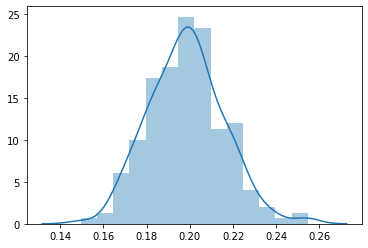

In [125]:
sns.distplot(fstSims, label='Fst in 32kb wins, n=20', norm_hist=True)

We are interested in understanding the divergence between two species and have been analysing Fst in windows of 32kb for a sample of 2 diploid individuals per species and have observed some tantalizing outliers.

## Divergence with constant migration

Let's (for now) assume that we have concrete information on the background demography and have estimated parameters under very simple null model of divergence with gene flow. Our cartoon history estimated from genome-wide data (we will give an example of how to do this using GimBL tomorrow) has four parameters: 

- a population split time $T$ (in generations) between pop0 and pop1
- a constant rate of unidirectional gene flow $m$ (per generation from pop1 to pop0) 
- two effective population sizes (we assume that the common ancestral pop has the same effective size as pop0). 

Assuming the same window size (32kb) and $r$ (1.84675e-8) as before, use msprime to obtain an upper critical value of $F_{st}$. 

How many windows in the Hmel Hcyd data show a significant $F_{st}$ given this demographic history? 

Is this more or less than expected?

In [113]:
#number of samples (2Xof diploid individuals) per deme:
sample_size = 5

#Rates for migration, recombination and mutation are unscaled and per generation:
mig = 3.8866e-7
seqLength = 32e3 
recr = 1.84675e-8
Ne0 = 2.3241e6
Ne1 = 9.8922e5 
splitT = 4.8580e6
mu = 1.9e-9

population_configurations = [
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne0),
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne1),
    ]
#demographic events are specified in the order they occur backwards in time:
# The MassMigration specifies the split between population 0 and 1: 
# backwards in time all lineages from the smaller population (1) are derived from pop (0)
# at time T 
demographic_events = [
    msprime.MassMigration(time=splitT, source=1, destination=0, proportion=1.0),
    ]
# migration matrix specifies a matrix of pairwise migration rates (backwards in time).
migration_matrix = [[0,0], [mig,0]]

KL: Not sure we need this: We can sprinkle mutations onto the treesequence and save variants as a vcf file as well as saving the treesequences themselves:

In [70]:
num_reps = 200
seed = np.random.randint(1, 2**32 - 1, 1)
#seed = np.random.randint(1, 2**32 - 1, 1)
replicates = msprime.simulate(
        num_replicates = num_reps,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix = [[0,0],[mig,0]],
        mutation_rate = mu,
        random_seed=seed)

In [107]:
for index, ts in enumerate(replicates):
#    msprime.mutate(ts, rate=mu, keep=True)
    with open('sim{}.vcf'.format(str(index)), 'w') as vcf_file:
        ts.write_vcf(vcf_file, ploidy=2)
    ts.dump('sim{}.trees'.format(str(index)))

We have simulated treesequences with mutations sprinkled on them. A simple way to compute Fst for each replicate window is to compare.

We will use the following Fst definition:

$F_{st}= \frac{T_b-T_w}{T_b+T_w}$

where $T_w$ and $T_b$ are the average pairwise coalescence times for a pair of lineages sampled within and between species respectively. Therefore an estimator of $F_{st}$ is:

$\hat{F_{st}}= \frac{d_{xy}-\pi}{d_{xy}+\pi}$

Note that the above follows from the general definition of $F_{st}$ in terms of expected pairwise coalescence times:

$F_{st}= \frac{T_t-T_w}{T_{t}}$

Where $T_t$ is the average for a pairwise sample taken at random. For the case of pops/species we assume that we are equally likely to sample from within and between species, so:

$T_t=(T_b + T_w)/2$

In [124]:
def comparison_within(p1):
    num_sites = p1.shape[0]
    num_comparisons = p1.shape[1]
    result = []
    for i in range(num_comparisons):
        p2 = np.roll(p1,1, axis=1)
        result.append(np.sum(np.mod(p1+p2, 2))/num_sites)
    return result

def comparison_between(p1,p2):
    num_sites = p1.shape[0]
    num_comparisons = p1.shape[1]
    result = []
    for i in range(num_comparisons):
        result.append(np.sum(np.mod(p1+p2, 2))/num_sites)
        p2 = np.roll(p2,1, axis=1)
    return result

def Fst(ts):
    n = ts.sample_size//2
    G = ts.genotype_matrix()
    p1 = G[:,:n]
    p2 = G[:,n:]
    within = (np.mean(comparison_within(p1)) + np.mean(comparison_within(p2)))/2
    between = np.mean(comparison_between(p1, p2))
    total = np.mean([between, within])
    return (total - within)/total

We estimate $F_{st}$ for each replicate using the tskit function Fst() and store the results in a numpy array:

In [ ]:
#histogram for unlinked windows 32kb
basic_short = pd.read_csv('basic_short_all.csv')
basic_short.drop(basic_short.columns[[0, 1]], axis=1, inplace=True)
current_winner_short = pd.read_csv('current_winner_short_all.csv')
current_winner_short.drop(current_winner_short.columns[[0, 1]], axis=1, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(current_winner_short['Fst'], label='current winner', norm_hist=True)
sns.distplot(fstsim , label='Fst')
plt.legend()
ax.set_xlim((0, 0.5))

A faster alternative is to compute $F_{st}$ from the tree sequence directly. This ignores the mutational variance in $F_{st}$.

We need to explain the awesomenes of the BranchLengthStatCalculator() here! Any summary statistic that can be defined in terms of branch lengths can be computed using this:

In [73]:
current_winner_short = pd.read_csv('current_winner_short_all.csv')
current_winner_short.drop(current_winner_short.columns[[0, 1]], axis=1, inplace=True)

(0, 0.5)

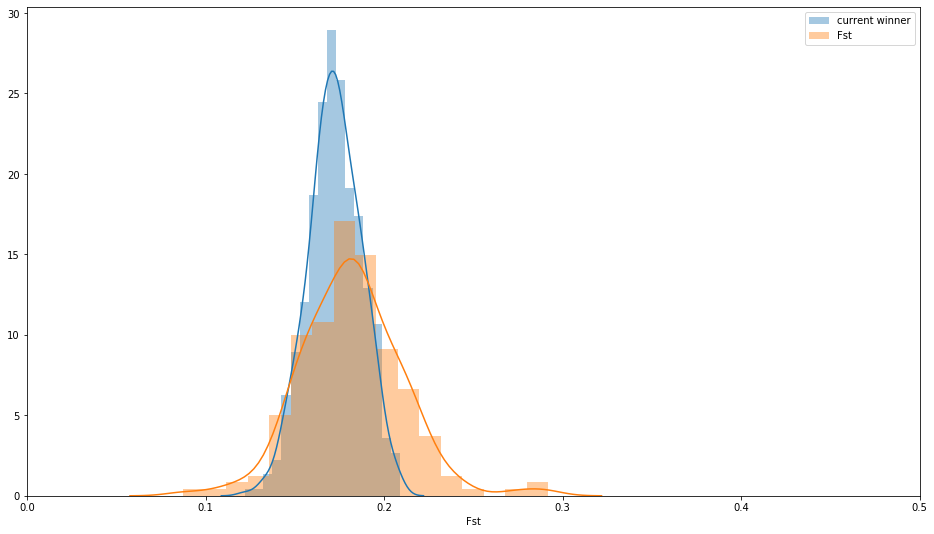

In [75]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(current_winner_short['Fst'], label='Fst in 32kb wins, n=20', norm_hist=True)
sns.distplot(fstSims , label='Fst in 32kb wins, n=2')
plt.legend()
ax.set_xlim((0, 0.4))

In [87]:
fstSims.mean(), np.quantile(fstSims,0.99), current_winner_short['Fst'].quantile(0.99)

(0.18188027232511061, 0.2710669509428636, 0.20487587223560247)

In [ ]:
current_winner_blocks = pd.read_csv('winner.window.variant.tsv', sep='\t')
current_winner_blocks.head()

or run all this in a script that can be run on multiple cores
change parametes within sim_chuncks.py as desired

In [ ]:
%run sim_chuncks.py

run tskit Fst scan and
analyse output using script as provided in the Fst_istogram notebook

In [ ]:
recomb = abs(np.random.normal(loc=1.846, scale=0.1, size=300))/1e8
replicates = msprime.simulate(
        num_replicates = 1,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix = [[0,0],
                            [mig,0]],
        mutation_rate = mu)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(abs(np.random.normal(loc=1.846, scale=0.1, size=300))/1e8, label='r in 32kb')
ax.set_xlim((1.2/1e8, 2.2/1e8))
plt.legend()

In [ ]:
#histogram for unlinked windows 32kb
basic_short = pd.read_csv('basic_short_all.csv')
basic_short.drop(basic_short.columns[[0, 1]], axis=1, inplace=True)
current_winner_short = pd.read_csv('current_winner_short_all.csv')
current_winner_short.drop(current_winner_short.columns[[0, 1]], axis=1, inplace=True)

## Divergence with secondary contact

How different is the distribution of $F_{st}$ if we assume that divergence happened in allopatry and has been partially eroded by secondary contact? We assume the same split time $T_{s}$ and $N_e$ as before and a sudden admixture event which transfers a proportion of $f=0.389$ from pop0 to pop1 at time $T_{ad}$. This is specified as another MassMigration event.

In [90]:
T = 4.8580e6
#time of secondary admixture
adT = 5.0772e4 
#proportion of lineages in source migrating into destination that split at time T:
proportionf =0.389 

population_configurations = [
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne0),
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne1),
    ]
    
#demographic events: specify in the order they occur backwards in time.
demographic_events = [
    msprime.MassMigration(time=adT, source=1, destination=0, proportion=proportionf),
    msprime.PopulationParametersChange(time=T, initial_size=Ne0, population_id=0),
    msprime.MassMigration(time=T, source=1, destination=0, proportion=1.0)
    ]

replicatesAD = msprime.simulate(
        num_replicates = num_reps,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events)

In [91]:
fstSimsAD = np.zeros(num_reps)
for index, ts in enumerate(replicatesAD):
    p1 = list(ts.get_samples(0))
    p2 = list(ts.get_samples(1))
    fstSimsAD[index] = calculate_Fst(ts,samplesets=[p1,p2])[0]

(0, 0.4)

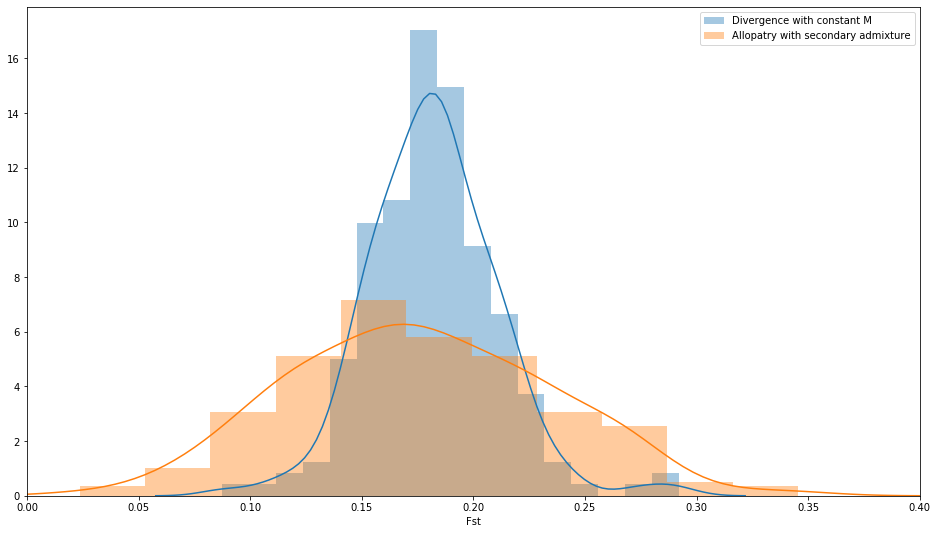

In [95]:
fig, ax = plt.subplots(figsize=(16,9))
fstIM = pd.Series(fstSims, name="Fst")
fstAD = pd.Series(fstSimsAD, name="Fst")
sns.distplot(fstIM,   label='Divergence with constant M')
sns.distplot(fstAD, label='Allopatry with secondary admixture')
plt.legend()
ax.set_xlim((0, 0.4))

The mean Fst is very similar for both models, the distribution is much broader under a model of recent admixture:

In [97]:
fstSims.mean(),fstSimsAD.mean()

(0.18188027232511061, 0.17625734232333878)

## Recombination rate heterogeneity

heli_32kb_Davey2017_rec is a dataframe with recombination rate estimates (cM/Mb) in 32kb windows estimated for Heliconius (Davey et al. 2017 generated three recombination maps for Hmel, Hcyd and the F1, the last column is the mean of these maps).

In [98]:
hapmap = pd.read_csv('heli_32kb_Davey2017_rec.csv', delimiter='\t')
hapmap.head()
#hapmap[hapmap['Chrom']==18]

,Chrom,start,end,Hmel,Hcyd,F1,Mean
0,1,465,93948,1.6382,3.3865,1.3737,2.1328
1,1,18722,109081,1.6372,3.3698,1.4416,2.1495
2,1,39996,116184,1.6364,3.3562,1.4992,2.1639
3,1,66980,122860,1.6355,3.3415,1.5672,2.1814
4,1,85341,131077,1.6349,3.3310,1.6206,2.1955


Note that 32kb is the total length of sequence in a window after filtering (in this case only intergenic data). So windows are substantially longer than 32 kb in terms of physical span.

- Note that using the postfiltering length rather than the span of windows is conservative: we are assuming a shorter map distance

- To make this more realistic one could bin windows by their span measured on the map.


median = 70.566kb


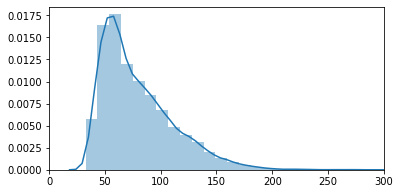

In [89]:
winspan=(hapmap['end']-hapmap['start'])/1000
fig, ax = plt.subplots(figsize=(6,3))
sns.distplot(winspan, label='window span')
ax.set_xlim((0, 300))
print("median = "+ str(winspan.median())+"kb")

The distribution of recombination rates across windows is wide:

2.015040450200432


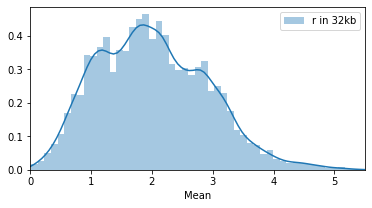

In [99]:
print(hapmap['Mean'].mean()/2)
fig, ax = plt.subplots(figsize=(6,3))
sns.distplot(hapmap['Mean']/2, label='r in 32kb')
ax.set_xlim((0, 5.5))
plt.legend()

We can draw a random sample from the empirical $r$ values and repeat the msprime simulation (200 replicates) under the IM model:

In [107]:
#simulate replicates with different recombination rates cfr. windows 
#specify a distribution to draw values from
recomb = np.random.choice(hapmap['Mean']/2,size=num_reps)

In [109]:
replicates_RecHet = [msprime.simulate(
        length = seqLength, 
        recombination_rate = rate/10e8,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix =  migration_matrix,
        mutation_rate = mu) for rate in recomb]

In [110]:
fstSims_RecHet = np.zeros(num_reps)
for index, ts in enumerate(replicates_RecHet):
    p1 = list(ts.get_samples(0))
    p2 = list(ts.get_samples(1))
    fstSims_RecHet[index] = calculate_Fst(ts,samplesets=[p1,p2])[0]

(0, 0.5)

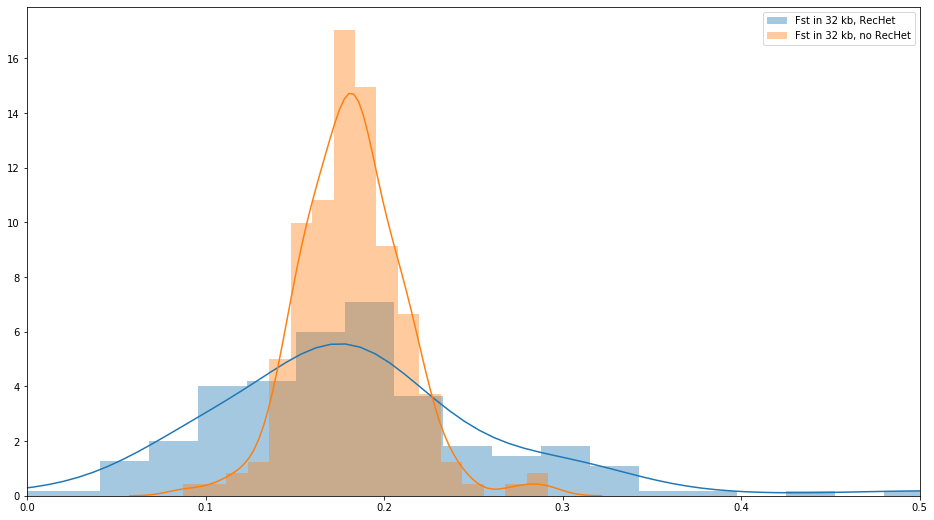

In [111]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(fstSims_RecHet, label='Fst in 32 kb, RecHet')
sns.distplot(fstSims, label='Fst in 32 kb, no RecHet')
plt.legend()
ax.set_xlim((0, 0.5))

$F_{st}$ has a much wider distribution if we include heterogeneity in recombination rate!!